In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from collections  import Counter
import math
import random
import numpy as np
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.nn import LSTM,GRU,Linear,Embedding,Transformer
import torch.optim as optim
from torch.nn.functional import logsigmoid
import time
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import pickle
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
original_files = ["original/o1","original/o2","original/o3","original/o4","original/o5"]
swapped_files = ["swapped/s1","swapped/s2","swapped/s3","swapped/s4","swapped/s5"]

In [ ]:
#loading sentences
length = []
original_sentences = []
words = Counter()
for file in original_files:
  with open("gdrive/MyDrive/data/{}.csv".format(file),encoding="utf-8") as f:
    csv_reader = csv.reader(f, delimiter=',')
    i = 0
    for r in csv_reader:
      if i == 0:
        i = 1
        continue
      length.append(int(r[4]))
      original_sentences.append(r[3])
      words.update(r[3].split())



In [ ]:
len(original_sentences), len(words)

(499995, 220264)

In [ ]:
print(max(length),min(length))

620 1


In [ ]:
sum([l>100 for l in length])

6178

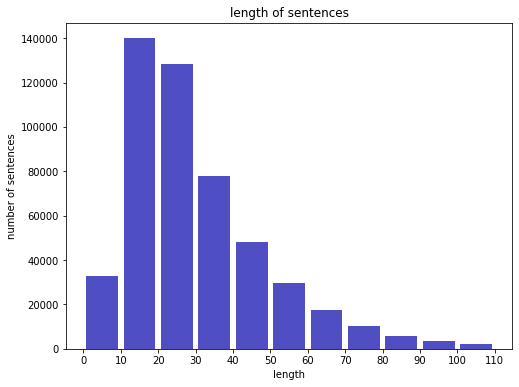

In [ ]:
#length histogram
# fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
plt.figure(figsize=(8,6))
plt.hist(length,bins=[10*i for i in range(12)],color='#0504aa',alpha=0.7, rwidth=0.85)
plt.xticks([10*i for i in range(12)])
plt.xlabel("length")
plt.title("length of sentences")
plt.ylabel("number of sentences")

plt.savefig("length_train.png",dpi=720)

In [ ]:
#word frequency
freq = [f for w,f in words.items()]
top_words = words.most_common(15)
print(top_words)

[('the', 1148625), ('of', 582429), ('and', 464204), ('in', 419369), ('to', 343700), ('a', 322733), ('is', 164647), ('as', 149668), ('was', 135943), ('for', 124622), ('s', 122047), ('that', 120963), ('by', 117970), ('with', 111697), ('on', 99563)]


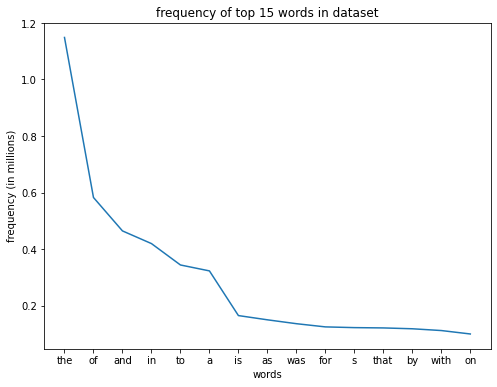

In [ ]:
#plot of top words
plt.figure(figsize=(8,6))
plt.plot([w for w,_ in top_words],[f for  _,f in top_words])
plt.yticks(ticks=[0.2*(10**6),0.4*(10**6),0.6*(10**6),0.8*(10**6),1*(10**6),1.2*(10**6)],labels=["0.2","0.4","0.6","0.8","1.0","1.2"])
plt.xlabel("words")
plt.ylabel("frequency (in millions)")
plt.title("frequency of top 15 words in dataset")
plt.savefig("word_freq_plot.png",dpi=720)

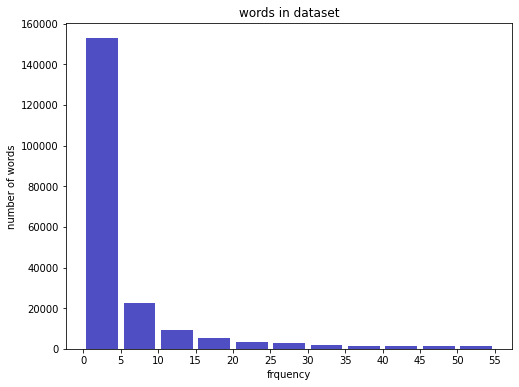

In [ ]:
#histogram of word frequency
plt.figure(figsize=(8,6))
plt.hist(freq,bins=[5*i for i in range(12)],color='#0504aa',alpha=0.7, rwidth=0.85)
plt.xticks([5*i for i in range(12)])
plt.xlabel("frquency")
plt.title("words in dataset")
plt.ylabel("number of words")

plt.savefig("word_freq.png",dpi=720)

In [ ]:
# !cp *.png gdrive/MyDrive/data/plots

In [ ]:
#analysis of male and female gendered words
male = []
female = []
with open("gender_list_1.csv".format(file),encoding="utf-8") as f:
    csv_reader = csv.reader(f, delimiter=',')
    i = 0
    for r in csv_reader:
      if i == 0:
        i = 1
        continue
      
      male.append(r[0].split(".")[0])
      female.append(r[1].split(".")[0])
     

Female word


In [ ]:
len(male),len(female)

(207, 207)

In [ ]:
#calculating there frequencys
freq_male = dict()
freq_female = dict()
for m in male:
  freq_male[m]=words[m]
for f in female:
  freq_female[f]=words[f]

In [ ]:
count = 0
top_words = []
for i in range(len(male)):
  c = freq_male[male[i]] + freq_female[female[i]]
  if c < 20:
    count += 1
  top_words.append([c,male[i],female[i],freq_male[male[i]],freq_female[female[i]]])
print(count)

60


In [ ]:
#finding top male and female words
top_words.sort(key=lambda x: -x[0])

In [ ]:
for i,v in enumerate(top_words[:20]):
  print(v[1],v[3],v[2],v[4],sep=",")

his,65130,her,12275
he,53889,she,7773
him,11126,her,12275
men,4385,women,4209
king,5409,queen,1383
father,3546,mother,2364
man,4061,woman,1518
son,3744,daughter,1664
god,4750,godess,0
himself,3297,herself,442
emperor,3175,empress,363
male,1627,female,1791
brother,1822,sister,1037
husband,757,wife,1951
lord,1490,lady,645
hubby,0,wife,1951
prince,1360,princess,360
governor,1474,governess,31
males,744,females,629
host,1142,hostess,13


In [ ]:
male_words, female_words, mwords_freqs, fwords_freqs = [], [], [], []
for v in top_words[:20]:
  male_words.append(v[0])
  mwords_freqs.append(v[1])
  female_words.append(v[2])
  fwords_freqs.append(v[3])

Plotting frequency of gender specific words in original data

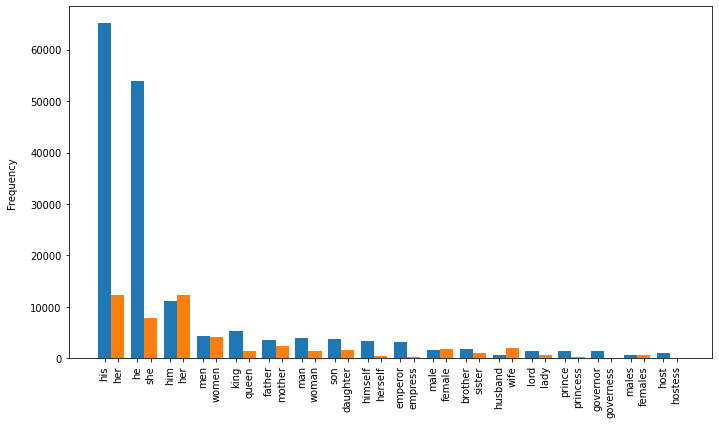

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(0, 2*len(male_words), 2)
# y1 = list(map(int, data[1]))
# y2 = list(map(int, data[3]))
width = 0.8

# plot data in grouped manner of bar type
ax.bar(x-width/2, mwords_freqs, width)
ax.bar(x + width/2, fwords_freqs, width)

ticks = []
for i in x:
  ticks.append(i - width/2)
  ticks.append(i + width/2)

labels = []
for _, (m, f) in enumerate(zip(male_words, female_words)):
  labels.append(m)
  labels.append(f)

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel("Frequency")
ax.yaxis.set_label_coords(-0.08,0.5)
plt.tight_layout()
plt.savefig('gender_word_freqs.png', dpi=200)
fig.show()

In [ ]:
sum(freq_male.values()) , sum(freq_female.values())

(195419, 45463)